In [38]:
import statsmodels.api as sm
import pandas as pd
from function import spearman_corr_heatmap
import numpy as np

In [34]:
df = pd.read_csv('../00_data/13_final/cbsa_level.csv')

In [43]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

rows = []

id_col = "cbsacode"
pop_col = "TotalPopulation"

# factors: all numeric except ID and population
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
factors = [c for c in numeric_cols if c not in [id_col, pop_col]]

for factor in factors:
    # keep only observations with positive Y and N for logs
    valid = (df[factor] > 0) & (df[pop_col] > 0)
    if valid.sum() < 3:
        continue  # not enough data points to fit

    y_log = np.log(df.loc[valid, factor])
    X = sm.add_constant(np.log(df.loc[valid, pop_col]))
    X.columns = ["const", f"log_{pop_col}"]

    model = sm.OLS(y_log, X).fit()

    # fitted log Y and SAMI (log residuals)
    yhat_log = model.predict(X)
    sami = y_log - yhat_log

    # slope & stats
    beta = model.params[f"log_{pop_col}"]
    pval = model.pvalues[f"log_{pop_col}"]
    ci_low, ci_up = model.conf_int().loc[f"log_{pop_col}"]
    logY0_hat = model.params["const"]

    # append one row per CBSA in the valid set
    for i, cbsa in df.loc[valid, id_col].items():
        rows.append({
            "cbsacode": cbsa,
            "factor": factor,
            "SAMI": float(sami.loc[i]),       # ξ_i = log-residual
            "beta": float(beta),
            "p_value": float(pval),
            "CI_lower": float(ci_low),
            "CI_upper": float(ci_up),
            "logY0_hat": float(logY0_hat),
            "n_used": int(valid.sum()),
            "r2": float(model.rsquared)
        })

results_df = pd.DataFrame(rows)

In [44]:
results_df.to_csv('../00_data/14_output/SAMIs_pop.csv')

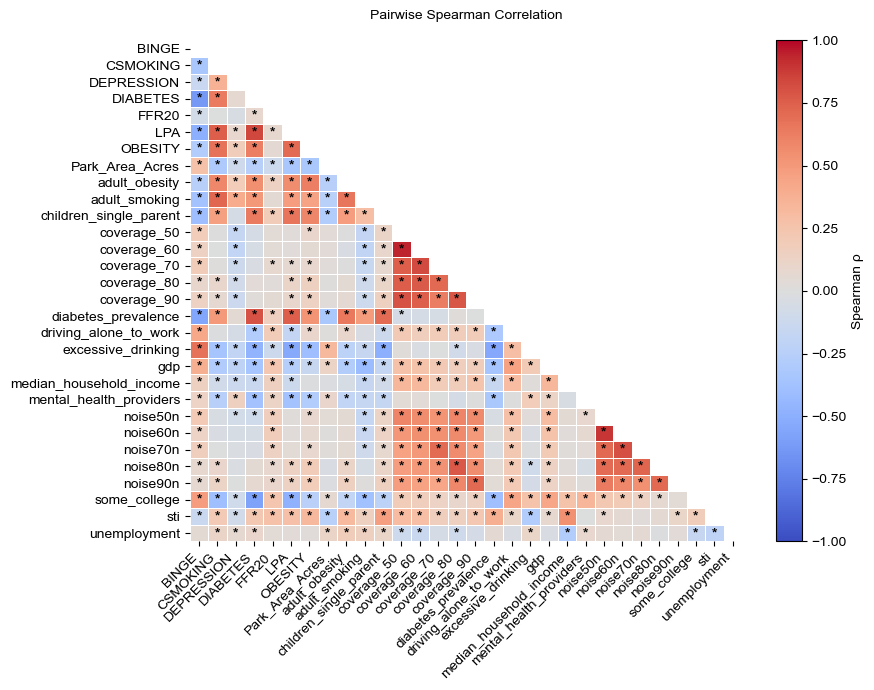

In [45]:

sami_wide = results_df.pivot(index="cbsacode", columns="factor", values="SAMI")

cols = [c for c in sami_wide.columns if c not in ['cbsacode']]
corr, pvals = spearman_corr_heatmap(sami_wide, columns=cols,figsize=(9, 7), savepath=None)